# day 253,day 255

# 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## ans:
1. **increase the number of epochs.**
2. **make the model more complex**:, add more layers to increase its complexity. if the model is too simple it may fail to capture all nuances and subtleties of the data resulting in a underfitting model.
3. **use Ensemble methods**: combining predictions from multiple models might help average out the simplicity of any single model in the group.
4. **multi-model modelling**: if we use multiple models to capture different patterns of the data generator say a camera captures visual information about the system while a audio sensor captures the auditory information, a ultraviolet rays detector might give information about the ultraviolet rays as the name implies. All together might give a better understanding of the system than any single device could give. This would reduce the chance of underfitting.
5. **use quality data.**
6. **incorporate more data**: if what you have is not enough then simply add more and try to weed out data that are of poor quality such as those that are not representative of the patterns you want your model to learn.
7. make sure the training and test sets are balanced.

# 2. Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test DataLoader's ready to use.

In [ ]:
# importing the essentials:
import torch
import torchvision
import requests,os,zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm
from PIL import Image
from pathlib import Path

In [ ]:
# make the files be ready:
# goals:

"""
1. make a directory to contain the zipfiles and another directory to contain the unzipped files.
2. download the files.
3. unzip the files and extract it to the intended location.
"""

zip_path = Path('data')
images_path = zip_path / 'images'

if images_path.is_dir():
  print("Directory has already been created! ")

else:
  print("we are now creating a new directory for containing the images: \n")
  images_path.mkdir(parents=True,exist_ok=True)

# downloading the file:
with open(Path(zip_path / 'data.zip'),'wb') as f:
  link = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip').content
  f.write(link)

# unzip the file:
with zipfile.ZipFile(Path(zip_path / 'data.zip'),'r') as zip:
  zip.extractall(images_path)
  zip.close()



we are now creating a new directory for containing the images: 



In [ ]:
# goals:
"""
1. create data augmentation/transformation techniques
2. create custom image folder
3. create DataLoaders to batchify
"""
# create data augmentation techniques
train_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=[64,64]),
    torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=31),
    torchvision.transforms.ToTensor()
])

test_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=[64,64]),
    torchvision.transforms.ToTensor()
])


# function for finding class names and class indices
def find_classes(directory):
  class_names = sorted(os.listdir(directory))

  if not class_names:
    raise FileNotFoundError("The Path '{}' doesn't seem right. please check it!! ".format(directory))
  class_idx = {}
  for index,names in enumerate(class_names):
    class_idx[names] = index

  return class_names,class_idx

# create custom_image_folder
class CustomImageFolder(torch.utils.data.Dataset):

  # initializer:
  def __init__(self,directory,transform=None):
    self.image_paths = list(Path(directory).glob('*/*.jpg'))
    self.transform = transform
    self.class_names , self.class_idx = find_classes(directory)

  # load image
  def load_image(self,index):
    return Image.open(self.image_paths[index])

  # overwrite the inbuilt len function to make it do our bid
  def __len__(self):
    return len(self.image_paths)

  # overwrite the get item function
  def __getitem__(self,index):
    img = self.load_image(index)
    class_name = self.image_paths[index].parent.stem
    label = self.class_idx[class_name]


    if self.transform:
      return self.transform(img),label
    else:
      return img,label


# creating custom datasets:
train_dir = 'data/images/train'
test_dir = 'data/images/test'

train_data = CustomImageFolder(directory=train_dir,transform=train_augmentation)
test_data = CustomImageFolder(directory=test_dir,transform=test_augmentation)

# create DataLoaders for batchification:
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=os.cpu_count())

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=os.cpu_count())




# 3. Recreate model_0 we built in section 7.

In [ ]:
# goals:
"""
1. subclass the torch.nn.Module
2. recreate the TinyVGG model from CNN explainer website
3. crete the model
4. compile the model with loss function,optimizer and accuracy.
5. fit the model for a certain number of epochs
"""

class TinyVGG(torch.nn.Module):
  def __init__(self,i,o,h):
    super().__init__()

    self.conv_block1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=i,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))

    )

    self.conv_block2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))
    )

    self.classifier_layer = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=h*3600,out_features=o)
    )

  def forward(self,input):
    x = self.conv_block1(input)
    # print(x.shape)
    x = self.conv_block2(x)
    # print(x.shape)
    x = self.classifier_layer(x)
    # print(x.shape)

    return x

# device agnostic code:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model0 = TinyVGG(i=3,o=len(train_data.class_names),h=10).to(device)

# compile the model
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(),
                             lr=0.001)
def accuracy(pred,actual):
  correct = torch.eq(pred,actual).sum().item()
  acc = correct/len(actual)
  return acc

def total_time(end,start):
  total = end - start
  print("Total Running Time was: {}".format(total))

# fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 5

# defining the containers to hold various losses and accuracies
trl = []
tsl = []
trc = []
tsc = []

start = time.perf_counter()
for epoch in tqdm(range(epochs)):
  # accumulated train_loss and test_loss
  a_train_loss, a_test_loss, a_train_acc, a_test_acc = 0,0,0,0

  # train the model
  model0.train()
  for x_train,y_train in train_dataloader:

    # making things device agnostic:
    x_trian,y_train = x_train.to(device),y_train.to(device)

    # getting train logits and train losses and accuracies
    train_logits = model0(x_train)
    train_predictions = train_logits.argmax(dim=1)
    train_pred_probs = torch.max(torch.softmax(train_logits,dim=1),dim=1)
    train_actuals = y_train
    train_loss = loss(train_logits,train_actuals)
    train_accuracy = accuracy(train_predictions,train_actuals)
    a_train_loss += train_loss
    a_train_acc += train_accuracy

    # zero grad the optimizer
    optimizer.zero_grad()

    # backpropogate the train loss
    train_loss.backward()

    # step the optimizer up a notch
    optimizer.step()


  # normalize the accumulated train_losses and train_accuracies
  a_train_loss /= len(train_dataloader)
  a_train_acc /= len(train_dataloader)

  # evaluation time

  model0.eval()
  with torch.inference_mode():
    for x_test,y_test in test_dataloader:

      x_test,y_test = x_test.to(device),y_test.to(device)

      test_logits = model0(x_test)
      test_predictions = test_logits.argmax(dim=1)
      test_actuals = y_test
      test_loss = loss(test_logits,test_actuals)
      test_accuracy = accuracy(test_predictions,test_actuals)
      a_test_loss += test_loss
      a_test_acc += test_accuracy


    # normalize the accumulations
    a_test_loss /= len(test_dataloader)
    a_test_acc /= len(test_dataloader)

    # print the results
    print('Epoch:{} | Train Loss:{:.3f}, Train Accuracy:{:.3f} | Test Loss:{:.3f}, Test Accuracy: {:.3f}'\
          .format(epoch,a_train_loss,a_train_acc,a_test_loss,a_test_acc))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0 | Train Loss:1.361, Train Accuracy:0.379 | Test Loss:1.603, Test Accuracy: 0.198
Epoch:1 | Train Loss:1.243, Train Accuracy:0.262 | Test Loss:1.063, Test Accuracy: 0.479
Epoch:2 | Train Loss:1.102, Train Accuracy:0.305 | Test Loss:1.090, Test Accuracy: 0.479
Epoch:3 | Train Loss:1.107, Train Accuracy:0.309 | Test Loss:1.102, Test Accuracy: 0.198
Epoch:4 | Train Loss:1.096, Train Accuracy:0.414 | Test Loss:1.103, Test Accuracy: 0.198


#4. Try training the model you made in exercise 3 for 10, 20 and 50 epochs, what happens to the results?
Use torch.optim.Adam() with a learning rate of 0.001 as the optimizer.

In [ ]:
# goals:
"""
# Train for 10 epochs
"""

class TinyVGG(torch.nn.Module):
  def __init__(self,i,o,h):
    super().__init__()

    self.conv_block1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=i,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))

    )

    self.conv_block2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))
    )

    self.classifier_layer = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=h*3600,out_features=o)
    )

  def forward(self,input):
    input = input.to(device)
    x = self.conv_block1(input)
    # print(x.shape)
    x = self.conv_block2(x)
    # print(x.shape)
    x = self.classifier_layer(x)
    # print(x.shape)

    return x

# device agnostic code:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model0 = TinyVGG(i=3,o=len(train_data.class_names),h=10).to(device)

# compile the model
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(),
                             lr=0.001)
def accuracy(pred,actual):
  correct = torch.eq(pred,actual).sum().item()
  acc = correct/len(actual)
  return acc

def total_time(end,start):
  total = end - start
  print("Total Running Time was: {}".format(total))

# fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10

# defining the containers to hold various losses and accuracies
trl = []
tsl = []
trc = []
tsc = []

start = time.perf_counter()
for epoch in tqdm(range(epochs)):
  # accumulated train_loss and test_loss
  a_train_loss, a_test_loss, a_train_acc, a_test_acc = 0,0,0,0

  # train the model
  model0.train()
  for x_train,y_train in train_dataloader:

    # making things device agnostic:
    x_trian,y_train = x_train.to(device),y_train.to(device)

    # getting train logits and train losses and accuracies
    train_logits = model0(x_train)
    train_predictions = train_logits.argmax(dim=1)
    train_pred_probs = torch.max(torch.softmax(train_logits,dim=1),dim=1)
    train_actuals = y_train
    train_loss = loss(train_logits,train_actuals)
    train_accuracy = accuracy(train_predictions,train_actuals)
    a_train_loss += train_loss
    a_train_acc += train_accuracy

    # zero grad the optimizer
    optimizer.zero_grad()

    # backpropogate the train loss
    train_loss.backward()

    # step the optimizer up a notch
    optimizer.step()


  # normalize the accumulated train_losses and train_accuracies
  a_train_loss /= len(train_dataloader)
  a_train_acc /= len(train_dataloader)

  # evaluation time

  model0.eval()
  with torch.inference_mode():
    for x_test,y_test in test_dataloader:

      x_test,y_test = x_test.to(device),y_test.to(device)

      test_logits = model0(x_test)
      test_predictions = test_logits.argmax(dim=1)
      test_actuals = y_test
      test_loss = loss(test_logits,test_actuals)
      test_accuracy = accuracy(test_predictions,test_actuals)
      a_test_loss += test_loss
      a_test_acc += test_accuracy


    # normalize the accumulations
    a_test_loss /= len(test_dataloader)
    a_test_acc /= len(test_dataloader)

    # print the results
    print('Epoch:{} | Train Loss:{:.3f}, Train Accuracy:{:.3f} | Test Loss:{:.3f}, Test Accuracy: {:.3f}'\
          .format(epoch,a_train_loss,a_train_acc,a_test_loss,a_test_acc))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0 | Train Loss:1.172, Train Accuracy:0.359 | Test Loss:1.311, Test Accuracy: 0.260
Epoch:1 | Train Loss:1.184, Train Accuracy:0.301 | Test Loss:1.100, Test Accuracy: 0.479
Epoch:2 | Train Loss:1.085, Train Accuracy:0.461 | Test Loss:1.097, Test Accuracy: 0.260
Epoch:3 | Train Loss:1.129, Train Accuracy:0.309 | Test Loss:1.119, Test Accuracy: 0.260
Epoch:4 | Train Loss:1.080, Train Accuracy:0.324 | Test Loss:1.089, Test Accuracy: 0.384
Epoch:5 | Train Loss:1.079, Train Accuracy:0.430 | Test Loss:1.085, Test Accuracy: 0.384
Epoch:6 | Train Loss:1.052, Train Accuracy:0.441 | Test Loss:1.076, Test Accuracy: 0.414
Epoch:7 | Train Loss:1.076, Train Accuracy:0.348 | Test Loss:1.028, Test Accuracy: 0.455
Epoch:8 | Train Loss:0.963, Train Accuracy:0.543 | Test Loss:1.015, Test Accuracy: 0.462
Epoch:9 | Train Loss:1.051, Train Accuracy:0.477 | Test Loss:0.971, Test Accuracy: 0.523


In [ ]:
# goals:
"""
# Train for 20 epochs
"""

class TinyVGG(torch.nn.Module):
  def __init__(self,i,o,h):
    super().__init__()

    self.conv_block1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=i,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))

    )

    self.conv_block2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))
    )

    self.classifier_layer = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=h*3600,out_features=o)
    )

  def forward(self,input):
    input = input.to(device)
    x = self.conv_block1(input)
    # print(x.shape)
    x = self.conv_block2(x)
    # print(x.shape)
    x = self.classifier_layer(x)
    # print(x.shape)

    return x

# device agnostic code:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model0 = TinyVGG(i=3,o=len(train_data.class_names),h=10).to(device)

# compile the model
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(),
                             lr=0.001)
def accuracy(pred,actual):
  correct = torch.eq(pred,actual).sum().item()
  acc = correct/len(actual)
  return acc

def total_time(end,start):
  total = end - start
  print("Total Running Time was: {}".format(total))

# fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 20

# defining the containers to hold various losses and accuracies
trl = []
tsl = []
trc = []
tsc = []

start = time.perf_counter()
for epoch in tqdm(range(epochs)):
  # accumulated train_loss and test_loss
  a_train_loss, a_test_loss, a_train_acc, a_test_acc = 0,0,0,0

  # train the model
  model0.train()
  for x_train,y_train in train_dataloader:

    # making things device agnostic:
    x_trian,y_train = x_train.to(device),y_train.to(device)

    # getting train logits and train losses and accuracies
    train_logits = model0(x_train)
    train_predictions = train_logits.argmax(dim=1)
    train_pred_probs = torch.max(torch.softmax(train_logits,dim=1),dim=1)
    train_actuals = y_train
    train_loss = loss(train_logits,train_actuals)
    train_accuracy = accuracy(train_predictions,train_actuals)
    a_train_loss += train_loss
    a_train_acc += train_accuracy

    # zero grad the optimizer
    optimizer.zero_grad()

    # backpropogate the train loss
    train_loss.backward()

    # step the optimizer up a notch
    optimizer.step()


  # normalize the accumulated train_losses and train_accuracies
  a_train_loss /= len(train_dataloader)
  a_train_acc /= len(train_dataloader)

  # evaluation time

  model0.eval()
  with torch.inference_mode():
    for x_test,y_test in test_dataloader:

      x_test,y_test = x_test.to(device),y_test.to(device)

      test_logits = model0(x_test)
      test_predictions = test_logits.argmax(dim=1)
      test_actuals = y_test
      test_loss = loss(test_logits,test_actuals)
      test_accuracy = accuracy(test_predictions,test_actuals)
      a_test_loss += test_loss
      a_test_acc += test_accuracy


    # normalize the accumulations
    a_test_loss /= len(test_dataloader)
    a_test_acc /= len(test_dataloader)

    # print the results
    print('Epoch:{} | Train Loss:{:.3f}, Train Accuracy:{:.3f} | Test Loss:{:.3f}, Test Accuracy: {:.3f}'\
          .format(epoch,a_train_loss,a_train_acc,a_test_loss,a_test_acc))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:0 | Train Loss:1.337, Train Accuracy:0.383 | Test Loss:1.551, Test Accuracy: 0.260
Epoch:1 | Train Loss:1.247, Train Accuracy:0.285 | Test Loss:1.088, Test Accuracy: 0.417
Epoch:2 | Train Loss:1.102, Train Accuracy:0.293 | Test Loss:1.096, Test Accuracy: 0.417
Epoch:3 | Train Loss:1.104, Train Accuracy:0.305 | Test Loss:1.103, Test Accuracy: 0.260
Epoch:4 | Train Loss:1.091, Train Accuracy:0.453 | Test Loss:1.095, Test Accuracy: 0.352
Epoch:5 | Train Loss:1.098, Train Accuracy:0.312 | Test Loss:1.047, Test Accuracy: 0.524
Epoch:6 | Train Loss:1.093, Train Accuracy:0.348 | Test Loss:1.103, Test Accuracy: 0.312
Epoch:7 | Train Loss:1.092, Train Accuracy:0.426 | Test Loss:1.107, Test Accuracy: 0.260
Epoch:8 | Train Loss:1.107, Train Accuracy:0.305 | Test Loss:1.111, Test Accuracy: 0.260
Epoch:9 | Train Loss:1.094, Train Accuracy:0.336 | Test Loss:1.074, Test Accuracy: 0.465
Epoch:10 | Train Loss:1.076, Train Accuracy:0.367 | Test Loss:1.047, Test Accuracy: 0.485
Epoch:11 | Train Los

In [ ]:
# goals:
"""
# Train for 50 epochs
"""

class TinyVGG(torch.nn.Module):
  def __init__(self,i,o,h):
    super().__init__()

    self.conv_block1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=i,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))

    )

    self.conv_block2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))
    )

    self.classifier_layer = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=h*3600,out_features=o)
    )

  def forward(self,input):
    input = input.to(device)
    x = self.conv_block1(input)
    # print(x.shape)
    x = self.conv_block2(x)
    # print(x.shape)
    x = self.classifier_layer(x)
    # print(x.shape)

    return x

# device agnostic code:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model0 = TinyVGG(i=3,o=len(train_data.class_names),h=10).to(device)

# compile the model
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(),
                             lr=0.001)
def accuracy(pred,actual):
  correct = torch.eq(pred,actual).sum().item()
  acc = correct/len(actual)
  return acc

def total_time(end,start):
  total = end - start
  print("Total Running Time was: {}".format(total))

# fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 50

# defining the containers to hold various losses and accuracies
trl = []
tsl = []
trc = []
tsc = []

start = time.perf_counter()
for epoch in tqdm(range(epochs)):
  # accumulated train_loss and test_loss
  a_train_loss, a_test_loss, a_train_acc, a_test_acc = 0,0,0,0

  # train the model
  model0.train()
  for x_train,y_train in train_dataloader:

    # making things device agnostic:
    x_trian,y_train = x_train.to(device),y_train.to(device)

    # getting train logits and train losses and accuracies
    train_logits = model0(x_train)
    train_predictions = train_logits.argmax(dim=1)
    train_pred_probs = torch.max(torch.softmax(train_logits,dim=1),dim=1)
    train_actuals = y_train
    train_loss = loss(train_logits,train_actuals)
    train_accuracy = accuracy(train_predictions,train_actuals)
    a_train_loss += train_loss
    a_train_acc += train_accuracy

    # zero grad the optimizer
    optimizer.zero_grad()

    # backpropogate the train loss
    train_loss.backward()

    # step the optimizer up a notch
    optimizer.step()


  # normalize the accumulated train_losses and train_accuracies
  a_train_loss /= len(train_dataloader)
  a_train_acc /= len(train_dataloader)

  # evaluation time

  model0.eval()
  with torch.inference_mode():
    for x_test,y_test in test_dataloader:

      x_test,y_test = x_test.to(device),y_test.to(device)

      test_logits = model0(x_test)
      test_predictions = test_logits.argmax(dim=1)
      test_actuals = y_test
      test_loss = loss(test_logits,test_actuals)
      test_accuracy = accuracy(test_predictions,test_actuals)
      a_test_loss += test_loss
      a_test_acc += test_accuracy


    # normalize the accumulations
    a_test_loss /= len(test_dataloader)
    a_test_acc /= len(test_dataloader)

    # print the results
    if epoch%10 == 0:
      print('Epoch:{} | Train Loss:{:.3f}, Train Accuracy:{:.3f} | Test Loss:{:.3f}, Test Accuracy: {:.3f}'\
            .format(epoch,a_train_loss,a_train_acc,a_test_loss,a_test_acc))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:0 | Train Loss:1.137, Train Accuracy:0.352 | Test Loss:1.266, Test Accuracy: 0.260
Epoch:10 | Train Loss:1.095, Train Accuracy:0.477 | Test Loss:1.095, Test Accuracy: 0.400
Epoch:20 | Train Loss:0.997, Train Accuracy:0.426 | Test Loss:1.203, Test Accuracy: 0.260
Epoch:30 | Train Loss:1.101, Train Accuracy:0.293 | Test Loss:1.097, Test Accuracy: 0.417
Epoch:40 | Train Loss:1.096, Train Accuracy:0.414 | Test Loss:1.098, Test Accuracy: 0.417


# 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# goals:
"""
1. Train for 10 epochs
2. change the hidden units from 10 to 20.

"""

class TinyVGG(torch.nn.Module):
  def __init__(self,i,o,h):
    super().__init__()

    self.conv_block1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=i,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))

    )

    self.conv_block2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))
    )

    self.classifier_layer = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=h*3600,out_features=o)
    )

  def forward(self,input):
    input = input.to(device)
    x = self.conv_block1(input)
    # print(x.shape)
    x = self.conv_block2(x)
    # print(x.shape)
    x = self.classifier_layer(x)
    # print(x.shape)

    return x

# device agnostic code:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model0 = TinyVGG(i=3,o=len(train_data.class_names),h=20).to(device)

# compile the model
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(),
                             lr=0.001)
def accuracy(pred,actual):
  correct = torch.eq(pred,actual).sum().item()
  acc = correct/len(actual)
  return acc

def total_time(end,start):
  total = end - start
  print("Total Running Time was: {}".format(total))

# fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10

# defining the containers to hold various losses and accuracies
trl = []
tsl = []
trc = []
tsc = []

start = time.perf_counter()
for epoch in tqdm(range(epochs)):
  # accumulated train_loss and test_loss
  a_train_loss, a_test_loss, a_train_acc, a_test_acc = 0,0,0,0

  # train the model
  model0.train()
  for x_train,y_train in train_dataloader:

    # making things device agnostic:
    x_trian,y_train = x_train.to(device),y_train.to(device)

    # getting train logits and train losses and accuracies
    train_logits = model0(x_train)
    train_predictions = train_logits.argmax(dim=1)
    train_pred_probs = torch.max(torch.softmax(train_logits,dim=1),dim=1)
    train_actuals = y_train
    train_loss = loss(train_logits,train_actuals)
    train_accuracy = accuracy(train_predictions,train_actuals)
    a_train_loss += train_loss
    a_train_acc += train_accuracy

    # zero grad the optimizer
    optimizer.zero_grad()

    # backpropogate the train loss
    train_loss.backward()

    # step the optimizer up a notch
    optimizer.step()


  # normalize the accumulated train_losses and train_accuracies
  a_train_loss /= len(train_dataloader)
  a_train_acc /= len(train_dataloader)

  # evaluation time

  model0.eval()
  with torch.inference_mode():
    for x_test,y_test in test_dataloader:

      x_test,y_test = x_test.to(device),y_test.to(device)

      test_logits = model0(x_test)
      test_predictions = test_logits.argmax(dim=1)
      test_actuals = y_test
      test_loss = loss(test_logits,test_actuals)
      test_accuracy = accuracy(test_predictions,test_actuals)
      a_test_loss += test_loss
      a_test_acc += test_accuracy


    # normalize the accumulations
    a_test_loss /= len(test_dataloader)
    a_test_acc /= len(test_dataloader)

    # print the results
    if epoch%1 == 0:
      print('Epoch:{} | Train Loss:{:.3f}, Train Accuracy:{:.3f} | Test Loss:{:.3f}, Test Accuracy: {:.3f}'\
            .format(epoch,a_train_loss,a_train_acc,a_test_loss,a_test_acc))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0 | Train Loss:1.425, Train Accuracy:0.355 | Test Loss:1.381, Test Accuracy: 0.260
Epoch:1 | Train Loss:1.172, Train Accuracy:0.426 | Test Loss:1.165, Test Accuracy: 0.260
Epoch:2 | Train Loss:1.123, Train Accuracy:0.285 | Test Loss:1.097, Test Accuracy: 0.412
Epoch:3 | Train Loss:1.113, Train Accuracy:0.375 | Test Loss:1.112, Test Accuracy: 0.280
Epoch:4 | Train Loss:1.079, Train Accuracy:0.387 | Test Loss:1.104, Test Accuracy: 0.393
Epoch:5 | Train Loss:1.079, Train Accuracy:0.359 | Test Loss:1.132, Test Accuracy: 0.302
Epoch:6 | Train Loss:1.080, Train Accuracy:0.363 | Test Loss:1.105, Test Accuracy: 0.322
Epoch:7 | Train Loss:1.064, Train Accuracy:0.426 | Test Loss:1.133, Test Accuracy: 0.342
Epoch:8 | Train Loss:1.009, Train Accuracy:0.512 | Test Loss:1.092, Test Accuracy: 0.427
Epoch:9 | Train Loss:1.200, Train Accuracy:0.293 | Test Loss:1.076, Test Accuracy: 0.418


# conclusion:
* no big change has happenend to the result

#7. Double the data you're using with your model and train it for 20 epochs, what happens to the results?
Note: You can use the custom data creation notebook to scale up your Food101 dataset.
You can also find the already formatted double data (20% instead of 10% subset) dataset on GitHub, you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# make the files be ready:
# goals:

"""
1. make a directory to contain the zipfiles and another directory to contain the unzipped files.
2. download the files.
3. unzip the files and extract it to the intended location.
"""

zip_path = Path('data')
images_path = zip_path / 'images_20_percent'

if images_path.is_dir():
  print("Directory has already been created! ")

else:
  print("we are now creating a new directory for containing the images: \n")
  images_path.mkdir(parents=True,exist_ok=True)

# downloading the file:
with open(Path(zip_path / 'data.zip'),'wb') as f:
  link = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip").content
  f.write(link)

# unzip the file:
with zipfile.ZipFile(Path(zip_path / 'data.zip'),'r') as zip:
  zip.extractall(images_path)
  zip.close()



we are now creating a new directory for containing the images: 



In [ ]:
# goals:
"""
1. create data augmentation/transformation techniques
2. create custom image folder
3. create DataLoaders to batchify
"""
# create data augmentation techniques
train_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=[64,64]),
    torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=31),
    torchvision.transforms.ToTensor()
])

test_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=[64,64]),
    torchvision.transforms.ToTensor()
])


# function for finding class names and class indices
def find_classes(directory):
  class_names = sorted(os.listdir(directory))

  if not class_names:
    raise FileNotFoundError("The Path '{}' doesn't seem right. please check it!! ".format(directory))
  class_idx = {}
  for index,names in enumerate(class_names):
    class_idx[names] = index

  return class_names,class_idx

# create custom_image_folder
class CustomImageFolder(torch.utils.data.Dataset):

  # initializer:
  def __init__(self,directory,transform=None):
    self.image_paths = list(Path(directory).glob('*/*.jpg'))
    self.transform = transform
    self.class_names , self.class_idx = find_classes(directory)

  # load image
  def load_image(self,index):
    return Image.open(self.image_paths[index])

  # overwrite the inbuilt len function to make it do our bid
  def __len__(self):
    return len(self.image_paths)

  # overwrite the get item function
  def __getitem__(self,index):
    img = self.load_image(index)
    class_name = self.image_paths[index].parent.stem
    label = self.class_idx[class_name]


    if self.transform:
      return self.transform(img),label
    else:
      return img,label


# creating custom datasets:
train_dir = 'data/images_20_percent/train'
test_dir = 'data/images_20_percent/test'

train_data = CustomImageFolder(directory=train_dir,transform=train_augmentation)
test_data = CustomImageFolder(directory=test_dir,transform=test_augmentation)

# create DataLoaders for batchification:
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=os.cpu_count())

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=os.cpu_count())




In [ ]:
# goals:
"""
1. Train for 20 epochs
2. change the hidden units from 10 to 20.

"""

class TinyVGG(torch.nn.Module):
  def __init__(self,i,o,h):
    super().__init__()

    self.conv_block1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=i,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),

        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))

    )

    self.conv_block2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=h,
                        out_channels=h,
                        kernel_size=(3,3),
                        stride=(1,1),
                        padding=(1,1)),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(3,3),stride=(1,1))
    )

    self.classifier_layer = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=h*3600,out_features=o)
    )

  def forward(self,input):
    input = input.to(device)
    x = self.conv_block1(input)
    # print(x.shape)
    x = self.conv_block2(x)
    # print(x.shape)
    x = self.classifier_layer(x)
    # print(x.shape)

    return x

# device agnostic code:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model0 = TinyVGG(i=3,o=len(train_data.class_names),h=20).to(device)

# compile the model
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(),
                             lr=0.001)
def accuracy(pred,actual):
  correct = torch.eq(pred,actual).sum().item()
  acc = correct/len(actual)
  return acc

def total_time(end,start):
  total = end - start
  print("Total Running Time was: {}".format(total))

# fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 20

# defining the containers to hold various losses and accuracies
trl = []
tsl = []
trc = []
tsc = []

start = time.perf_counter()
for epoch in tqdm(range(epochs)):
  # accumulated train_loss and test_loss
  a_train_loss, a_test_loss, a_train_acc, a_test_acc = 0,0,0,0

  # train the model
  model0.train()
  for x_train,y_train in train_dataloader:

    # making things device agnostic:
    x_trian,y_train = x_train.to(device),y_train.to(device)

    # getting train logits and train losses and accuracies
    train_logits = model0(x_train)
    train_predictions = train_logits.argmax(dim=1)
    train_pred_probs = torch.max(torch.softmax(train_logits,dim=1),dim=1)
    train_actuals = y_train
    train_loss = loss(train_logits,train_actuals)
    train_accuracy = accuracy(train_predictions,train_actuals)
    a_train_loss += train_loss
    a_train_acc += train_accuracy

    # zero grad the optimizer
    optimizer.zero_grad()

    # backpropogate the train loss
    train_loss.backward()

    # step the optimizer up a notch
    optimizer.step()


  # normalize the accumulated train_losses and train_accuracies
  a_train_loss /= len(train_dataloader)
  a_train_acc /= len(train_dataloader)

  # evaluation time

  model0.eval()
  with torch.inference_mode():
    for x_test,y_test in test_dataloader:

      x_test,y_test = x_test.to(device),y_test.to(device)

      test_logits = model0(x_test)
      test_predictions = test_logits.argmax(dim=1)
      test_actuals = y_test
      test_loss = loss(test_logits,test_actuals)
      test_accuracy = accuracy(test_predictions,test_actuals)
      a_test_loss += test_loss
      a_test_acc += test_accuracy


    # normalize the accumulations
    a_test_loss /= len(test_dataloader)
    a_test_acc /= len(test_dataloader)

    # print the results
    if epoch%2 == 0:
      print('Epoch:{} | Train Loss:{:.3f}, Train Accuracy:{:.3f} | Test Loss:{:.3f}, Test Accuracy: {:.3f}'\
            .format(epoch,a_train_loss,a_train_acc,a_test_loss,a_test_acc))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:0 | Train Loss:1.246, Train Accuracy:0.302 | Test Loss:1.077, Test Accuracy: 0.425
Epoch:2 | Train Loss:1.070, Train Accuracy:0.433 | Test Loss:0.952, Test Accuracy: 0.535
Epoch:4 | Train Loss:1.049, Train Accuracy:0.479 | Test Loss:0.927, Test Accuracy: 0.567
Epoch:6 | Train Loss:1.017, Train Accuracy:0.450 | Test Loss:0.975, Test Accuracy: 0.485
Epoch:8 | Train Loss:0.981, Train Accuracy:0.485 | Test Loss:0.905, Test Accuracy: 0.545
Epoch:10 | Train Loss:0.980, Train Accuracy:0.492 | Test Loss:0.890, Test Accuracy: 0.571
Epoch:12 | Train Loss:0.991, Train Accuracy:0.521 | Test Loss:0.883, Test Accuracy: 0.590
Epoch:14 | Train Loss:0.960, Train Accuracy:0.565 | Test Loss:0.885, Test Accuracy: 0.616
Epoch:16 | Train Loss:0.999, Train Accuracy:0.510 | Test Loss:0.894, Test Accuracy: 0.545
Epoch:18 | Train Loss:0.965, Train Accuracy:0.531 | Test Loss:0.872, Test Accuracy: 0.572


# conclusion:

* it has improved the model's performance a great bit!

# 8.Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

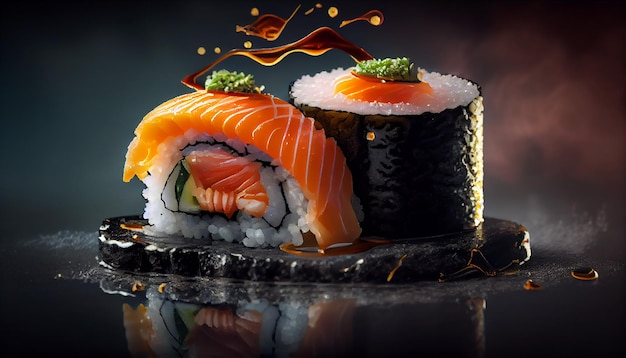

In [ ]:
# goal

'''
1. download the image and store in a folder named freethrows
2. show the image
3. preprocess the image for the model to accept it.
4. make prediction
5. check the prediction with the actual label
'''

freethrows_path = Path('freethrows')

freethrows_path.mkdir(parents=True,exist_ok=True)

# download the image
with open(Path(freethrows_path / 'image.jpg'),'wb') as f:
  link = requests.get('https://img.freepik.com/free-photo/painting-sushi-plate-with-picture-fish-it_188544-12221.jpg?size=626&ext=jpg&ga=GA1.1.1222169770.1702252800&semt=ais').content
  f.write(link)


# show image
Image.open('freethrows/image.jpg')


In [ ]:
# preprocess the image

# setting the path
free_images_path = list(freethrows_path.glob('*.jpg'))

# select a random image
index = np.random.randint(len(free_images_path))

# read the image using torchvision.io.read_image and change it datatype to float32 and  it
image = torchvision.io.read_image(str(free_images_path[index])).type(torch.float32)/255.

# make it have the same shape as those training images
augmentations = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=[64,64])
])

image = augmentations(image)

# increase a dimension for batch
image = image.unsqueeze(dim=0)

image.shape,image.dtype

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([1, 3, 64, 64]), torch.float32)

In [ ]:
class_names = train_data.class_names

# predict on the image
model0.eval()
with torch.inference_mode():
  logits = model0(image)
  prediction = logits.argmax(dim=1)
  pred_prob = torch.max(torch.softmax(logits,dim=1))

print("The Model's prediction is: '{}' \n with probability of: {:.3f}%"\
      .format(class_names[prediction],pred_prob*100))

The Model's prediction is: 'sushi' 
 with probability of: 61.485%


In [ ]:
train_data.class_names

['pizza', 'steak', 'sushi']

# conclusion:
* in order to further improve the model's performance we could use:
   1. transfer learning.

# Extra curriculum:

# ec1: To practice your knowledge of PyTorch Dataset's and DataLoader's through PyTorch datasets and dataloaders tutorial notebook.

## did i learn anything new?
* i have learned that we use indices to access the contents of the disk.

# day 257

# ec2: Spend 10-minutes reading the PyTorch torchvision.transforms documentation.

## what did i learn?

* i have learned that instead of using torchvision.transforms we have to use torchvision.transforms.v2 for better performance. v2 stands for version2.

## to improve the performance do the following:
1. use torchvision.transforms.v2
2. convert PIL image to tensor for faster processing. we can do that with: torchvision.transforms.v2.ToImage(pil_image)
3. when resizing use antialias=True and make sure the dtype is either torch.float32 or torch.unint8
4.  look at this page for details: https://pytorch.org/vision/stable/transforms.html
5. Most transform classes and functionals support torchscript. For composing transforms, `use torch.nn.Sequential` instead of torchvision.transforms.Compose:

In [ ]:
import torchvision.transforms.v2

# ec3:

## some datasets that stood out to me are:

1. caltech256:
2. moleculenet:


## how could i try building a model on it?

1. i can use this model to make the model focus only on the subject filtering the uninformative background when it sees an object.
2. moleculenet: provides datasets to train your model to classify the molecules in quantum physics, chemistry, biology and so on. use pip install deepchem


In [ ]:
pip install deepchem[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 24.4 MB/s eta 0:00:00


# ec4 To speed up deep learning models, you can do a few tricks to improve compute, memory and overhead computations, for more read the post Making Deep Learning Go Brrrr From First Principles by Horace He.


## what did i learn?

* using this strategies we can make the GPU do the computation and our operations can be less RAM intensive as it used to be.

* metrics for checking the efficiency of any deep any algorithms:

  * One way to think about compute is as a factory. We send instructions to our factory (overhead), send it materials (memory-bandwidth), all to keep our factory running efficiently (compute).


   1. `compute`: TIME spent computing the floating point operations.optimized state: how fast the calculations can be done?

   2. `memory`: TIME spent on transferring the data between different locations in the GPU. optimized state: how less of a memory our program can consume? solution: instead of sending the output with minimal computation done on it to the global memory and retrieving it back for doing further computations, do all the computations at once in a single place and send the output to the global memory location(RAM or Harddisk).

   example:
   instead of writing:
   x = self.conv_block1(input)
   x = self.con_block2(x)
   x = self.classifier(x)
   return x

   write:
   return self.classifier(self.conv_block2(self.conv_block1(input)))

   **This will save a lot of back and forth memory transportations**




   3. `overhead`: other things.

   * overhead is anything other than memory and compute such as the speed of execution in python versus c++, the speed of pytorch vs tensorflow

   * For example, if you double your batch size but your runtime only increases by 10%, you're likely overhead bound.



   
  

# ec 5: look at torch dynamo for overhead optimization.

In [1]:
import torch._dynamo